In [4]:
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import sklearn

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix, hstack, vstack, diags, eye
import scipy as sp
from scipy.spatial.distance import pdist, squareform
import scipy.sparse as sps

from typing import Union


In [5]:
class Tree:

    __tree = None
    __adj_matrix = None
    node_count = None

    def __init__(self,
                 tree: Union[sklearn.tree._classes.DecisionTreeClassifier,
                             sklearn.tree._classes.DecisionTreeRegressor,
                             sklearn.tree._classes.ExtraTreeClassifier,
                             sklearn.tree._classes.ExtraTreeRegressor],
                 make_adj_matrix: bool = True):

        self.__tree = tree.tree_
        self.node_count = self.__tree.node_count

        if make_adj_matrix: self.adjacency_matrix()


    def adjacency_matrix(self, sparse=True):
        """
        Create an adjacency matrix in CSR format for the given decision tree.
        """
        tree = self.__tree

        n_nodes = tree.node_count
        children_left = tree.children_left
        children_right = tree.children_right

        row_indices = []
        col_indices = []

        for node in range(n_nodes):
            if children_left[node] != children_right[node]:  # Internal node
                row_indices.extend([node, node])
                col_indices.extend([children_left[node], children_right[node]])

        self.__adj_matrix = sps.csr_matrix((np.ones(len(row_indices)), (row_indices, col_indices)),
                                           shape=(n_nodes, n_nodes), dtype=int)
    def get_tree(self) -> sklearn.tree._tree.Tree:
        return self.__tree

    def get_adj_matrix(self, sparse=True) -> sps._csr.csr_matrix:
        if self.__adj_matrix is not None:
            self.adjacency_matrix()
        return self.__adj_matrix if sparse else self.__adj_matrix.toarray()




In [217]:
class Embedding:

    __space_type = None
    __tree = None
    tree_adj_mat = None
    __alphas = None
    __lap = None
    __eigvals = None
    __eigvecs = None

    def __init__(self, tree: Tree, space_type: str = 'Euclidean', alphas: np.ndarray = None):
        self.__tree = tree
        self.tree_adj_mat = self.__tree.get_adj_matrix()
        self.__space_type = space_type

    def make_eigenmaps(self, embed_dim: int,
                       normed: bool = False,
                       symmetrized: bool = True):

        lap, lap_diag = sps.csgraph.laplacian(self.tree_adj_mat.astype('float32'),
                                     normed=normed, symmetrized=symmetrized, return_diag=True)

        if self.__space_type == 'Euclidean':
            lap *= -1
            lap += sps.eye(*lap.shape)
            eigvals, eigvecs = sps.linalg.eigsh(lap, k=embed_dim+1, sigma=1.0, which='LM')

            # dropping zero eigenvalue along with constant eigenvector

            eigvals = 1 - eigvals[:-1]
            eigvecs = eigvecs[:, :-1] / lap_diag[:, None]

        elif self.__space_type == 'Hyperbolic':

            """Create a hyperbolic Laplacian matrix for a given adjacency matrix
                and alpha vector.

            If the `alpha_arr` that tracks the connections of our artificial node
            is not given, it is assumed that all alphas are equal, and the vector
            is normalized.

            We symmetrize the g_adj_matrix if the corresponding flag is given
            (and by default).
            Note that this just means adding its conjugate transpose, which
            will corrupt the weights if they are partially symmetrized already
            or double them if they are fully symmetrized.

            :param g_adj_matrix: Sparse adjacency matrix of the graph.
            :param alpha_arr: Vector of alpha values, if present.
            :param symmetrize: Whether to symmetrize the adjacency matrix
            :return: Sparse hyperbolic Laplacian matrix.
            """
            lap = lap.tocsr()

            if self.__alphas is None:
                self.__alphas = np.full(self.tree_adj_mat.shape[0],
                                        1. / self.tree_adj_mat.shape[0])

            # Now we make the diagonal equal the standard Laplacian diag
            # minus alpha_arr:
            lap = (lap - sps.diags(self.__alphas, offsets=0, format='csr'))

            top = sps.hstack(
                (sps.csr_matrix([[-np.add.reduce(self.__alphas)]]),
                sps.csr_matrix(self.__alphas)))
            bottom_rows = sps.hstack(
                (sps.csr_matrix(self.__alphas).T,
                lap), format='csr')

            lap = sps.vstack((top, bottom_rows), format='csr')

            # print(lap.todense().shape)
            # print(lap.todense())
            # eigvals, eigvecs = sps.linalg.eigsh(lap, k=embed_dim+1, which='LM')
            if embed_dim+1 == lap.shape[0]:
                eigvals, eigvecs = sp.linalg.eigh(lap.toarray(), check_finite=False)
            else:
                eigvals, eigvecs = sps.linalg.eigsh(lap, k=embed_dim+1, which='SM')
            # eigvals = eigvals[::-1]
            # eigvecs = np.fliplr(eigvecs)
            # eigvals, eigvecs = sps.linalg.eigsh(lap.toarray(), k=embed_dim+1, which='SM')

            # dropping zero eigenvalue along with constant eigenvector

            # eigvals, eigvecs = eigvals[1:], eigvecs[:, 1:]

        else:
            print('Type not supported')
            self.__eigvals = None
            self.__eigvecs = None
            self.__lap = None

        self.__eigvals = eigvals
        self.__eigvecs = eigvecs
        self.__lap = lap

    def get_eigenmaps(self, embed_dim: int = None,
                     normed: bool = False,
                     symmetrized: bool = True) -> tuple[np.ndarray]:

        if self.__eigvals is None:
            if embed_dim is None:
                embed_dim = self.__tree.node_count // 3
            self.make_eigenmaps(embed_dim=embed_dim, normed=normed,
                                symmetrized=symmetrized)

        return self.__eigvals, self.__eigvecs

    def get_laplacian(self, embed_dim: int = None,
                      normed: bool = False,
                      symmetrized: bool = True,
                      sparse: bool = True) -> sps.csr_matrix:
        if self.__lap is None:
            if embed_dim is None:
                embed_dim = self.__tree.node_count // 3
            self.make_eigenmaps(embed_dim, normed=normed,
                                symmetrized=symmetrized)
        if sparse:
            return self.__lap
        else:
            return self.__lap.toarray()

    def plot_eigen_dependency(self, idx_1, idx_2, title='Graph with Edges'):
        x = self.__eigvecs[:, idx_1]
        y = self.__eigvecs[:, idx_2]

        plt.scatter(x, y)

        # Draw edges
        rows, cols = self.tree_adj_mat.nonzero()
        for i in range(len(rows)):
            plt.plot([x[rows[i]], x[cols[i]]], [y[rows[i]], y[cols[i]]], 'k-', alpha=0.5)

        plt.xlabel('Eigenvector 1')
        plt.ylabel('Eigenvector 2')
        plt.title(title)
        # plt.savefig(title+'.png')
        plt.show()

# Tests

Generating a decision-tree based on the MNIST dataset

In [8]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [9]:
clf = DecisionTreeClassifier(max_depth=4)

# Train the classifier
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

Converting the obtained `sklearn.tree` into the custom `Tree` instance, the contained tree is stored as an object + its adjacency matrix in the compressed `csr` format.

In [14]:
simple_tree = Tree(clf)

In [23]:
print(simple_tree.get_adj_matrix().todense().shape)

(31, 31)


Creating the `Embedding` instance from the obtained tree.

In [280]:
embed_2 = Embedding(simple_tree, space_type='Hyperbolic')

Obtaining the eigenmap generated by the Hyperbolic Laplacian matrix and rescaling each eigenvector by the inverse square root of the corresponding eigenvalue: $e_\lambda^{(i)} \mapsto e_\lambda^{(i)} \cdot 1/\sqrt{\lambda_i}$. Such scaling will adjust the L2-norms of the eigenvectors, according to their "importance" in the eigenmap.

In [290]:
eigvals, eigvecs = embed_2.get_eigenmaps(embed_dim=10)

In [291]:
eigvecs.shape

(32, 11)

In [292]:
eigvals[0], eigvals[1]

(-2.7909558369392344e-17, 0.008053396672999954)

In [293]:
# Now we do this outside the function!
eigvals, eigvecs = eigvals[1:], eigvecs[:, 1:]

In [271]:
# eigvals[1] = abs(eigvals[1])  # if negative eigenval is included

In [294]:
eigvals[0] = abs(eigvals[0])

In [295]:
print(eigvals)

[0.0080534  0.06453001 0.06453001 0.23569113 0.23569113 0.23569113
 0.23569113 0.67949632 0.96774194 0.96774194]


In [296]:
eigvecs_rescaled = eigvecs[:, 2:] * (1 / np.sqrt(eigvals[2:]))

Removing the eigenvector, corresponding to $\alpha$'s in Hyper Laplacian.

In [297]:
true_eigvecs_rescaled = eigvecs_rescaled[1:,:]

In [298]:
distances = np.triu(squareform(pdist(true_eigvecs_rescaled)))

In [277]:
# distances = eigvecs_rescaled.T @ embed_2.get_laplacian(embed_dim=31) @ eigvecs_rescaled

In [279]:
# distances[2, 3]

1.1102230246251565e-16

[]

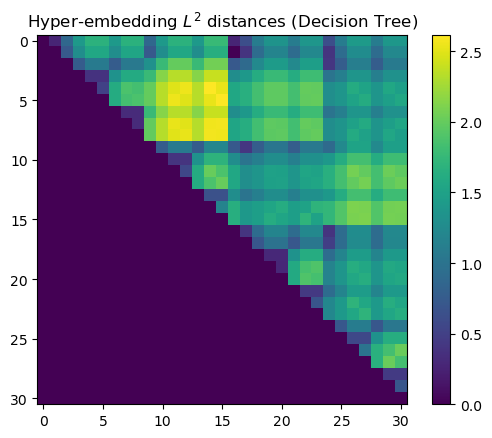

In [299]:
plt.imshow(distances)
plt.title('Hyper-embedding $L^2$ distances (Decision Tree)')
plt.colorbar()
plt.plot()

[]

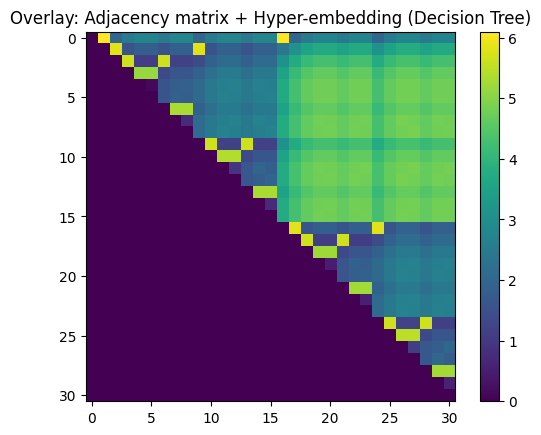

In [200]:
plt.imshow(distances + np.max(distances) * embed_2.tree_adj_mat.toarray())
plt.title('Overlay: Adjacency matrix + Hyper-embedding (Decision Tree)')
plt.colorbar()
plt.plot()

[]

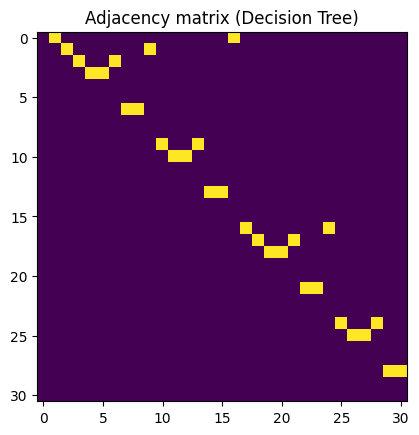

In [201]:
plt.imshow(embed_2.tree_adj_mat.toarray())
plt.title('Adjacency matrix (Decision Tree)')
plt.plot()

Reconstruction based on the distance matrix: two nodes are connected if the L2-distance between their embeddings is equal and minimal in the corresponding row:

In [205]:
sot = np.sort(distances, axis=1)
minimal_ones = []
for i in range(sot.shape[0] - 2):
    minimal_ones.append(sot[i, np.nonzero(sot[i,:])[0][:2]])

minimals = np.array(minimal_ones)

assert np.array_equal(np.nonzero((minimals[:,1] - minimals[:,0]).round(5))[0], np.where(np.all(embed_2.tree_adj_mat.toarray() == 0.0, axis=1))[0][:-2])

If the above lines terminated with no error, then there is a straight-forward reconstruction from the obtained embeddings back to the original graph.

Now let's make things more interesting: Let us introduce an additional edge to the tree hierarchy, so that we get a cycle:

In [212]:
adj = embed_2.tree_adj_mat.toarray()
np.put(adj, 8, 1)
adj = sps.csr_matrix(adj)
embed_2.tree_adj_mat = adj

Let's repeat the very same steps:

In [213]:
eigvals_spoiled, eigvecs_spoiled = embed_2.get_eigenmaps(10)
eigvecs_resc_spoiled = eigvecs_spoiled * (1 / np.sqrt(eigvals_spoiled))
true_eigvecs_resc_spoiled = eigvecs_resc_spoiled[1:,:]
distances_spoiled = np.triu(squareform(pdist(true_eigvecs_resc_spoiled)))

[]

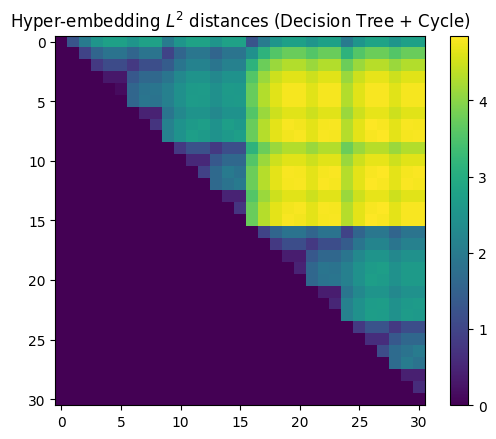

In [214]:
plt.imshow(distances_spoiled)
plt.title('Hyper-embedding $L^2$ distances (Decision Tree + Cycle)')
plt.colorbar()
plt.plot()

[]

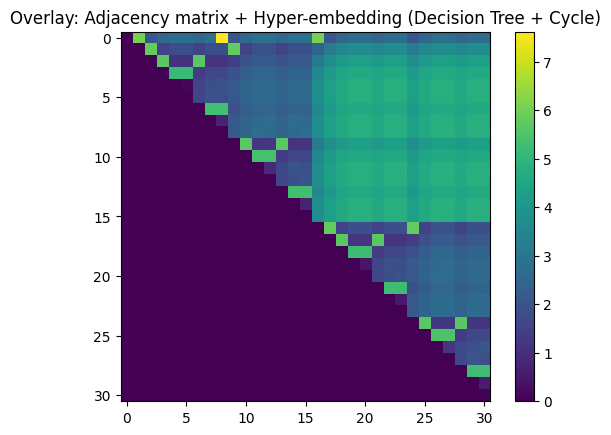

In [215]:
plt.imshow(distances_spoiled + np.max(distances_spoiled) * embed_2.tree_adj_mat.toarray())
plt.title('Overlay: Adjacency matrix + Hyper-embedding (Decision Tree + Cycle)')
plt.colorbar()
plt.plot()

[]

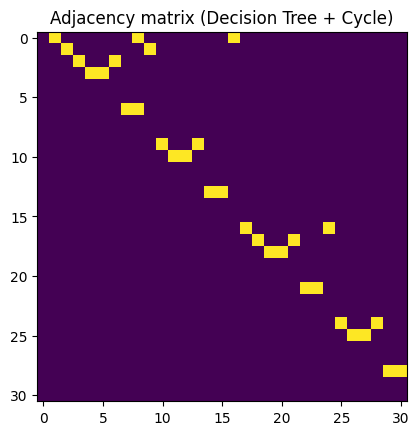

In [216]:
plt.imshow(embed_2.tree_adj_mat.toarray())
plt.title('Adjacency matrix (Decision Tree + Cycle)')
plt.plot()

### Auxiliary code

The latter code was made to understand how graph embeddings relate to one another in terms of representing the graph (something like analysing principle components, but not quite). We do not use it right now.

In [ ]:
def project_vertices(eigvecs):
    """
    Project vertices onto a 2D plane using components from three eigenvectors.

    The function uses a projection formula where each vertex `i` is mapped to a 2D point.
    The coordinates for each vertex are computed using components of three different eigenvectors
    (x, y, z) obtained from the hyperbolic Laplacian. The projection formula is as follows:

    x-coordinate: (x_i/x_0) - (y_i/y_0)
    y-coordinate: (x_i/x_0) - (z_i/z_0)

    where x_i, y_i, z_i are the components of the eigenvectors for vertex `i`,
    and x_0, y_0, z_0 are the components of the eigenvectors for the "zeroth" vertex,
    an additional component in the hyperbolic Laplacian.

    Parameters:
    eigvecs (numpy.ndarray): An array of eigenvectors obtained from the hyperbolic Laplacian.

    Returns:
    tuple: Two numpy arrays representing the projected x and y coordinates of the vertices.
    """
    x, y, z = eigvecs[:, 0], eigvecs[:, 1], eigvecs[:, 2]
    x0, y0, z0 = x[0], y[0], z[0]

    projected_x = x / x0 - y / y0
    projected_y = x / x0 - z / z0

    return projected_x, projected_y

In [ ]:
def plot_projected_graph(projected_x, projected_y, adjacency_matrix, title='Projected Graph with 3 eigenvectors'):
    plt.scatter(projected_x, projected_y)
    rows, cols = adjacency_matrix.nonzero()
    for i in range(len(rows)):
        plt.plot([projected_x[rows[i]], projected_x[cols[i]]], [projected_y[rows[i]], projected_y[cols[i]]], 'k-', alpha=0.5)

    plt.xlabel('Projected X')
    plt.ylabel('Projected Y')
    plt.title(title)
    plt.show()


<AxesSubplot:>

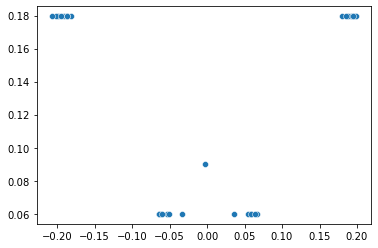

In [ ]:
sns.scatterplot(x=eigvecs_rf[:, -2], y=eigvecs_rf[:, -1])

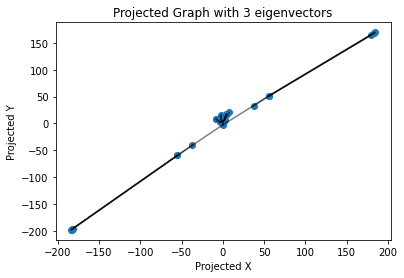

In [ ]:
eigvals_rf, eigvecs_rf = laplacian_eigenmaps(adj_matrix_rf, embed_dim=3)
projected_x, projected_y = project_vertices(eigvecs_rf)

plot_projected_graph(projected_x, projected_y, adj_matrix_rf)

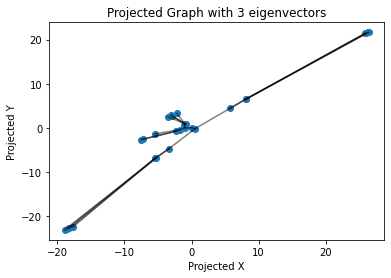

In [ ]:
eigvals_gb, eigvecs_gb = laplacian_eigenmaps(adj_matrix_gb, embed_dim=3)
projected_x, projected_y = project_vertices(eigvecs_gb)

plot_projected_graph(projected_x, projected_y, adj_matrix_gb)

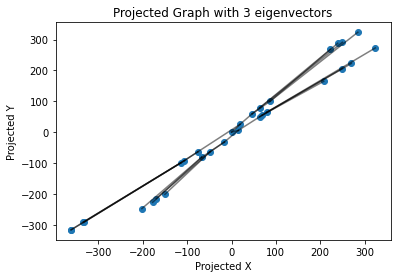

In [ ]:
eigvals_et, eigvecs_et = laplacian_eigenmaps(adj_matrix_et, embed_dim=3)
projected_x, projected_y = project_vertices(eigvecs_et)

plot_projected_graph(projected_x, projected_y, adj_matrix_et)

In [ ]:
def ccw(A, B, C):
    return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

def check_edge_crossing(p1, p2, q1, q2):
    return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

def plot_projected_graph(projected_x, projected_y, adjacency_matrix, title='Projected Graph with 3 eigenvectors'):
    plt.scatter(projected_x, projected_y)

    # Get all edges from the adjacency matrix
    rows, cols = adjacency_matrix.nonzero()
    edges = list(zip(rows, cols))

    # Check for cycles and plot edges
    for i, (row, col) in enumerate(edges):
        edge_color = 'k-'  # Default color for edges
        for j in range(i + 1, len(edges)):  # Check for crossing with subsequent edges
            other_row, other_col = edges[j]
            if check_edge_crossing((projected_x[row], projected_y[row]), (projected_x[col], projected_y[col]),
                                   (projected_x[other_row], projected_y[other_row]), (projected_x[other_col], projected_y[other_col])):
                edge_color = 'r-'  # Change color to red if there is a crossing
                break  # Stop checking if we found a crossing
        plt.plot([projected_x[row], projected_x[col]], [projected_y[row], projected_y[col]], edge_color, alpha=0.5)

    plt.xlabel('Projected X')
    plt.ylabel('Projected Y')
    plt.title(title)
    plt.show()

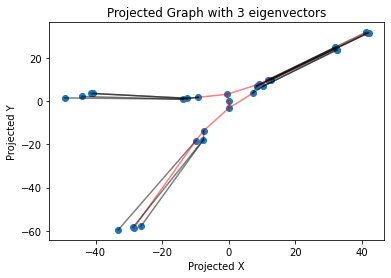

In [ ]:
eigvals_rf, eigvecs_rf = laplacian_eigenmaps(adj_matrix_rf, embed_dim=3)
projected_x, projected_y = project_vertices(eigvecs_rf)

plot_projected_graph(projected_x, projected_y, adj_matrix_rf)

In hyperbolic geometry, lines can diverge more quickly than in Euclidean space due to the negative curvature. When projecting a graph into 2D hyperbolic space, one might expect fewer intersections between edges because of this divergence. However, intersections can still occur, particularly in areas of the graph where the structure is dense or complex.